In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pickle
import tqdm
import time
import math

from random import choice

In [144]:
f = h5py.File('second_sample.hdf5','r')

print(f.keys())
print(f['data'].attrs.keys())
print(f['data'].attrs['title'])
print(f['data'].attrs['descr'])
print(f['data'].attrs['columns'])

rawdata = np.copy(f['data'])
f.close()

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['N', 'columns', 'descr', 'title']>
First fake dataset
Here is where we can leave notes on how we made the data set...
0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type


In [145]:
rawdata.shape

(100000, 4104)

In [146]:
freq =   rawdata[:,   0:2048]
flux =   rawdata[:,2048:4096]
opzs = 1+rawdata[:,4096]

In [147]:
### Define function that turns the edges of the wavelengths and 
### number of samples and position into (1+z) under the assumption it was HII

def con_pos2opz(index, leftedge,rightedge,num):
    return (index/num*(rightedge-leftedge)+leftedge)/(6562.8/1e4)

def con_opz2pos(opz, leftedge,rightedge,num):
    return (opz*(6562.8/1e4)-leftedge)/(rightedge-leftedge)*num



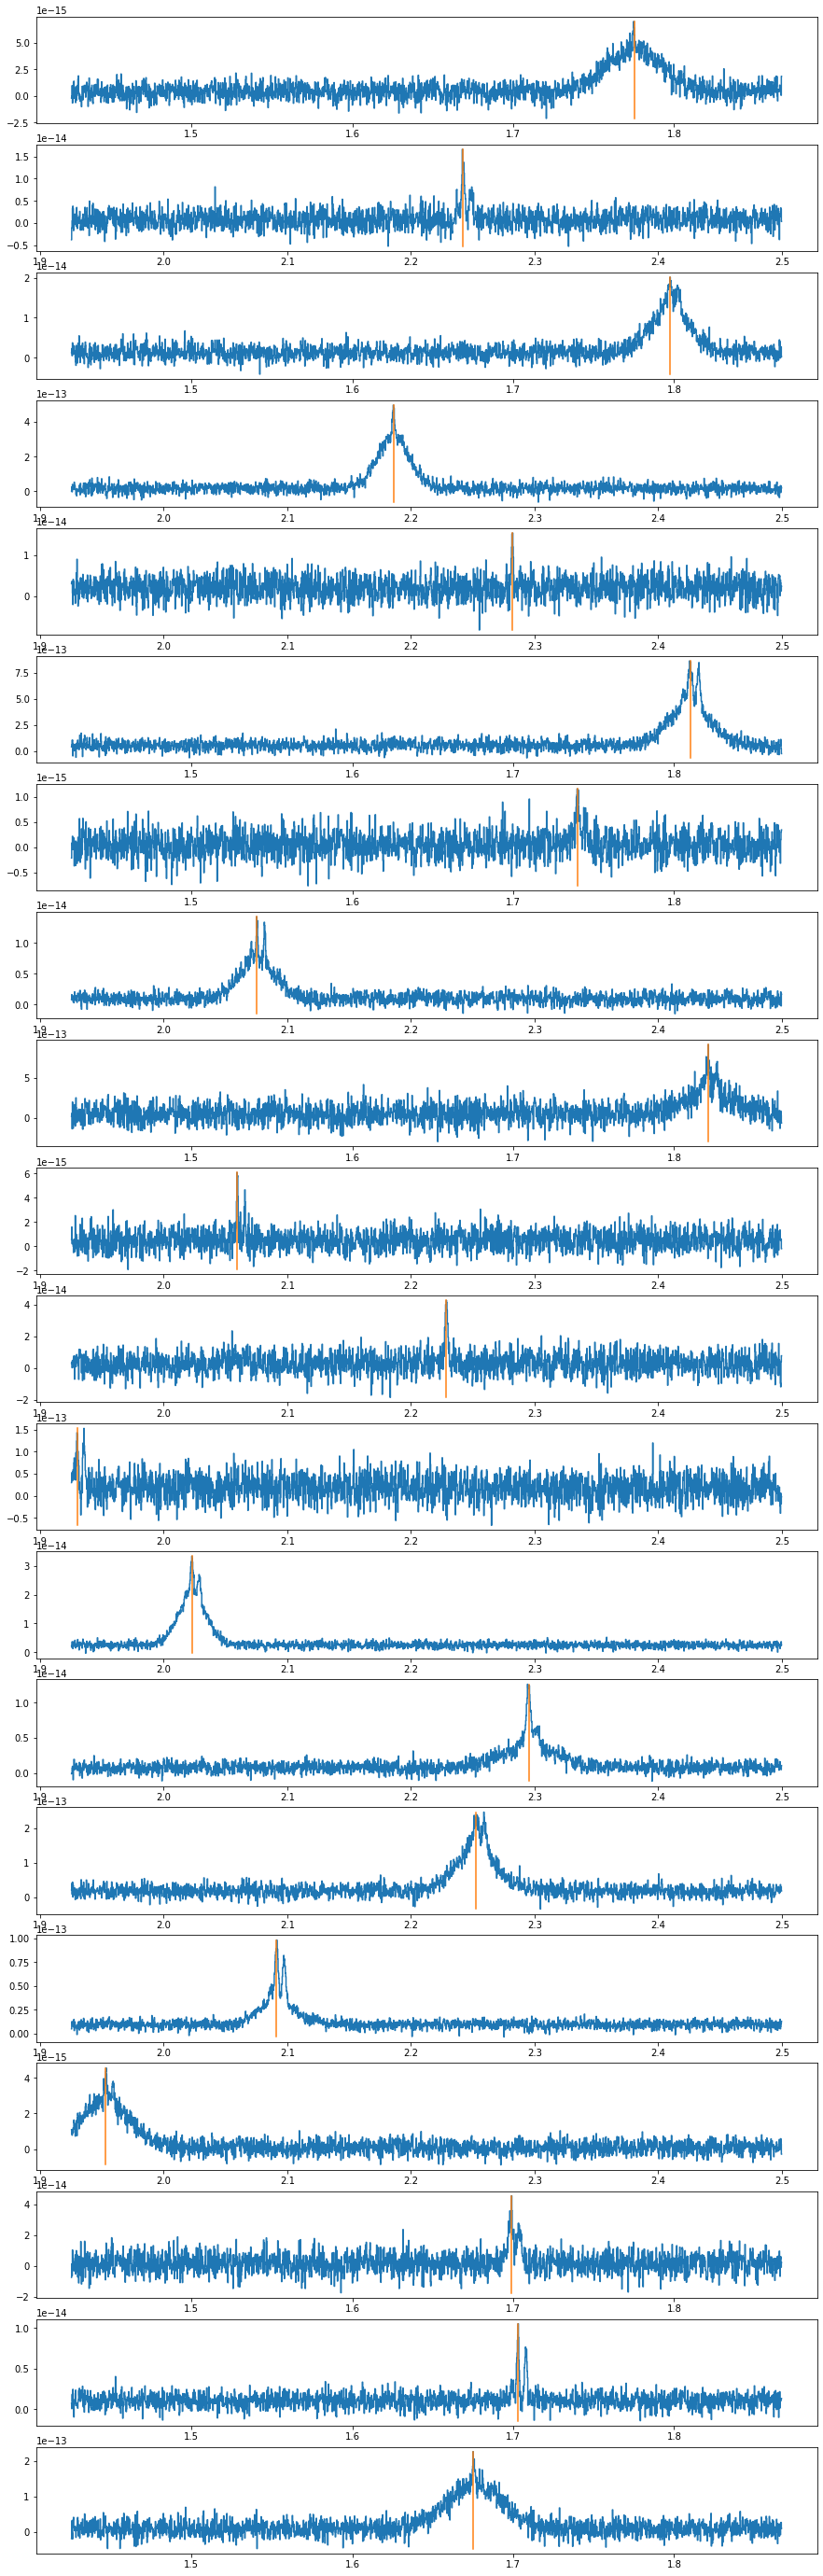

In [148]:
toshow = 20
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(offset,offset+toshow):
    plt.subplot(toshow,1,i+1-offset)
    plt.plot(freq[i],flux[i],drawstyle='steps-mid')
    guess = int(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048))
    plt.plot([freq[i,guess],freq[i,guess]],[np.min(flux[i]),np.max(flux[i])])
plt.show()

## First make a rough guess on z by looking for the maximum and then bind a window around it.

### First check this is not too wrong

In [149]:
## I am going to soften the flux, that way I can remove the spurious maxima

softflux7 = np.zeros_like(flux)
softflux3 = np.zeros_like(flux)

for i in tqdm.tqdm(range(len(flux))):
    softflux7[i] = np.convolve(flux[i],np.ones(7)/7,'same')
    softflux3[i] = np.convolve(flux[i],np.ones(3)/3,'same')

100%|██████████| 100000/100000 [00:10<00:00, 9551.01it/s]


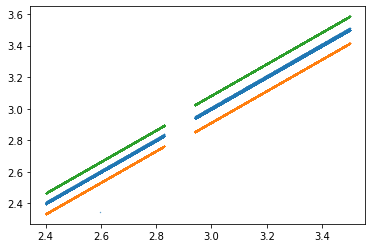

In [150]:
opz_guess3 = con_pos2opz(np.argmax(softflux3,axis=1),freq[:,0],freq[:,-1],2048)
opz_guess7 = con_pos2opz(np.argmax(softflux7,axis=1),freq[:,0],freq[:,-1],2048)

## These show the window that of 200 pixels in each direction...
opz_guess_l = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)-200,freq[:,0],freq[:,-1],2048)
opz_guess_h = con_pos2opz(con_opz2pos(opzs,freq[:,0],freq[:,-1],2048)+200,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs,opz_guess3,s=0.1)
plt.scatter(opzs,opz_guess_l,s=0.01)
plt.scatter(opzs,opz_guess_h,s=0.01)
#plt.scatter(opzs,opz_guess_h,s=0.1)

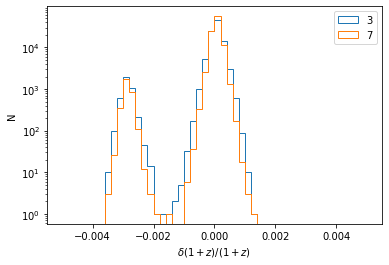

99999.0
100000.0


In [151]:
## Another way to see this:

k3 = plt.hist((opzs-opz_guess3)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='3')
k5 = plt.hist((opzs-opz_guess7)/opzs,bins=np.linspace(-.005,.005,51),histtype='step',label='7')
plt.legend()
plt.yscale('log')
plt.ylabel('N')
plt.xlabel(r'$\delta (1+z)/(1+z)$')
plt.show()
print(np.sum(k3[0]))
print(np.sum(k5[0]))

## Now that we have a good rough knowledge of z, we can choose a window. And rescale...

In [176]:
nconvert = len(rawdata)
#nconvert = 20
window = 200
wfreq = np.zeros((nconvert,int(2*window+1)))
wflux = np.zeros((nconvert,int(2*window+1)))
wpos_tr = np.zeros(nconvert)
wpos_gs = np.zeros(nconvert)
wshift = np.zeros(nconvert)

for i in tqdm.tqdm(range(nconvert)):       
    posc_o = int(np.round(con_opz2pos(opz_guess7[i],freq[i,0],freq[i,-1],2048)))
    posc_true = int(np.round(con_opz2pos(opzs[i],freq[i,0],freq[i,-1],2048)))
    posc = np.min([np.max([window,posc_o]),2047-window])
    posh = posc + window
    posl = posc - window
    wshift[i] = posl
    wpos_tr[i] = int(posc_true - posl)
    wpos_gs[i] = int(posc_o - posl)
    y1 = flux[i,posl:posh+1]
    x1 = freq[i,posl:posh+1]
    
    ym = np.mean(flux[i])
    yv = np.var(flux[i])
    
    #print(posc,posl,posh,posh-posl)
    wflux[i] = (y1-ym)/np.sqrt(yv)
    wfreq[i] = x1   

100%|██████████| 100000/100000 [00:11<00:00, 8679.17it/s]


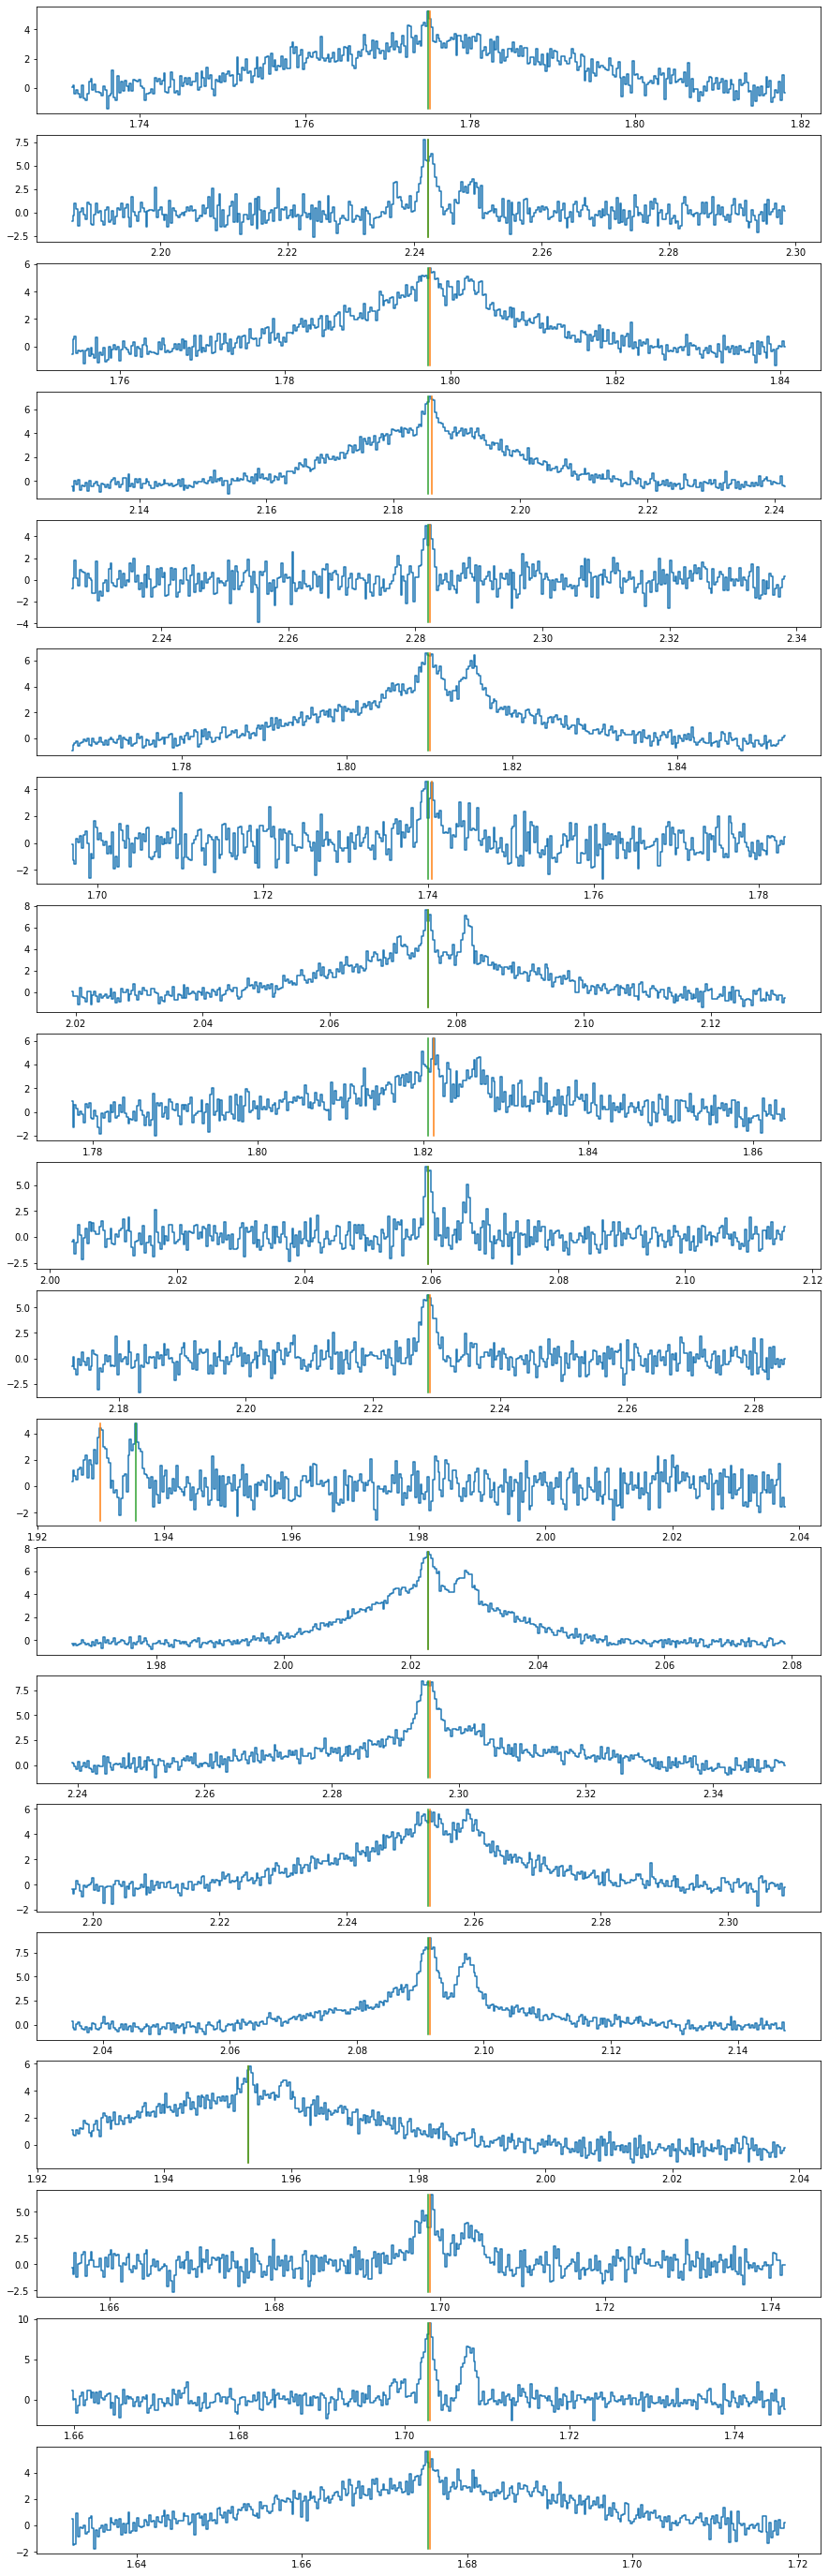

In [153]:
## Let us have a look
toshow = 20
offset = 400
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],[np.min(wflux[i+offset]),np.max(wflux[i+offset])])

plt.show()

# Do the thing: Use NN to try to guess z

In [234]:
from keras.models import Sequential
from keras.layers import Dense

## Split data into training and evaluation

NN = len(wfreq)
train_frac = 0.8
train_N = int(train_frac * NN)
print(train_N)

## Define test and training data

trainx = wflux[0:train_N]
trainy = wpos_tr[0:train_N]

testx  = wflux[train_N:]
testy  = wpos_tr[train_N:]

80000


In [402]:
## Define Neural networks and compare

model_001 = Sequential()
model_001.add(Dense(400, input_dim=(2*window+1), activation='elu'))
model_001.add(Dense(400, activation='elu'))
model_001.add(Dense(400, activation='elu'))
model_001.add(Dense(400, activation='elu'))
model_001.add(Dense(20, activation='elu'))
model_001.add(Dense(1))
model_001.compile(loss='mean_squared_error', optimizer='adam')

In [403]:
model_002 = Sequential()
model_002.add(Dense(400, input_dim=(2*window+1), activation='relu'))
model_002.add(Dense(400, activation='relu'))
model_002.add(Dense(400, activation='relu'))
model_002.add(Dense(400, activation='relu'))
model_002.add(Dense(20, activation='relu'))
model_002.add(Dense(1))
model_002.compile(loss='mean_squared_error', optimizer='adam')

In [404]:
model_003 = Sequential()
model_003.add(Dense(800, input_dim=(2*window+1), activation='relu'))
model_003.add(Dense(400, activation='relu'))
model_003.add(Dense(400, activation='relu'))
model_003.add(Dense(400, activation='relu'))
model_003.add(Dense(20, activation='relu'))
model_003.add(Dense(1))
model_003.compile(loss='mean_squared_error', optimizer='adam')


In [405]:
## Run the damned training sessions

history_001 = model_001.fit(trainx, trainy, epochs=80, verbose=2, shuffle=True, validation_split=0.1)
print("done with 001")

Epoch 1/80
2250/2250 - 8s - loss: 190.0367 - val_loss: 16.8898
Epoch 2/80
2250/2250 - 7s - loss: 43.4863 - val_loss: 18.0073
Epoch 3/80
2250/2250 - 7s - loss: 11.8405 - val_loss: 15.9447
Epoch 4/80
2250/2250 - 7s - loss: 17.1807 - val_loss: 13.3363
Epoch 5/80
2250/2250 - 7s - loss: 11.7605 - val_loss: 11.7314
Epoch 6/80
2250/2250 - 7s - loss: 5.9009 - val_loss: 5.9322
Epoch 7/80
2250/2250 - 7s - loss: 3.4992 - val_loss: 7.0903
Epoch 8/80
2250/2250 - 7s - loss: 2.9856 - val_loss: 3.7125
Epoch 9/80
2250/2250 - 8s - loss: 3.7207 - val_loss: 13.3974
Epoch 10/80
2250/2250 - 7s - loss: 2.5410 - val_loss: 12.1996
Epoch 11/80
2250/2250 - 7s - loss: 30.1624 - val_loss: 4.8911
Epoch 12/80
2250/2250 - 7s - loss: 3.7327 - val_loss: 5.4422
Epoch 13/80
2250/2250 - 6s - loss: 2.1576 - val_loss: 3.9492
Epoch 14/80
2250/2250 - 6s - loss: 1.9447 - val_loss: 4.5914
Epoch 15/80
2250/2250 - 6s - loss: 1.6473 - val_loss: 4.6391
Epoch 16/80
2250/2250 - 7s - loss: 67.7556 - val_loss: 4.0522
Epoch 17/80
2250/2

In [406]:
history_002 = model_002.fit(trainx, trainy, epochs=80, verbose=2, shuffle=True, validation_split=0.1)
print("done with 001")

Epoch 1/80
2250/2250 - 13s - loss: 450.7610 - val_loss: 138.6546
Epoch 2/80
2250/2250 - 11s - loss: 111.8982 - val_loss: 89.7945
Epoch 3/80
2250/2250 - 11s - loss: 79.1158 - val_loss: 115.0305
Epoch 4/80
2250/2250 - 12s - loss: 62.1110 - val_loss: 92.3921
Epoch 5/80
2250/2250 - 12s - loss: 52.4770 - val_loss: 46.6706
Epoch 6/80
2250/2250 - 12s - loss: 44.0723 - val_loss: 61.6373
Epoch 7/80
2250/2250 - 11s - loss: 33.7869 - val_loss: 37.4374
Epoch 8/80
2250/2250 - 10s - loss: 29.1089 - val_loss: 35.9389
Epoch 9/80
2250/2250 - 10s - loss: 21.1675 - val_loss: 23.4546
Epoch 10/80
2250/2250 - 10s - loss: 15.0343 - val_loss: 25.4042
Epoch 11/80
2250/2250 - 10s - loss: 13.9901 - val_loss: 28.6303
Epoch 12/80
2250/2250 - 10s - loss: 12.4851 - val_loss: 18.1163
Epoch 13/80
2250/2250 - 10s - loss: 11.3980 - val_loss: 22.7552
Epoch 14/80
2250/2250 - 10s - loss: 12.5375 - val_loss: 25.2701
Epoch 15/80
2250/2250 - 11s - loss: 10.5230 - val_loss: 16.0441
Epoch 16/80
2250/2250 - 10s - loss: 8.3487 - 

In [ ]:
history_003 = model_003.fit(trainx, trainy, epochs=80, verbose=2, shuffle=True, validation_split=0.1)
print("done with 003")

Epoch 1/80
2250/2250 - 15s - loss: 521.4506 - val_loss: 144.7372
Epoch 2/80
2250/2250 - 15s - loss: 117.9441 - val_loss: 166.3824
Epoch 3/80
2250/2250 - 15s - loss: 81.4498 - val_loss: 79.4322
Epoch 4/80
2250/2250 - 15s - loss: 68.4549 - val_loss: 62.4429
Epoch 5/80
2250/2250 - 15s - loss: 56.7458 - val_loss: 93.7102
Epoch 6/80
2250/2250 - 15s - loss: 50.1517 - val_loss: 80.4153
Epoch 7/80
2250/2250 - 15s - loss: 41.1277 - val_loss: 80.9301
Epoch 8/80
2250/2250 - 15s - loss: 38.0020 - val_loss: 95.7201
Epoch 9/80
2250/2250 - 15s - loss: 34.1730 - val_loss: 50.6153
Epoch 10/80
2250/2250 - 15s - loss: 28.6848 - val_loss: 54.6073
Epoch 11/80
2250/2250 - 15s - loss: 28.4979 - val_loss: 44.7541
Epoch 12/80
2250/2250 - 15s - loss: 26.4863 - val_loss: 44.3066
Epoch 13/80
2250/2250 - 15s - loss: 21.8522 - val_loss: 42.4575
Epoch 14/80
2250/2250 - 15s - loss: 21.7521 - val_loss: 41.4810
Epoch 15/80
2250/2250 - 15s - loss: 20.6178 - val_loss: 42.4277
Epoch 16/80
2250/2250 - 15s - loss: 19.1231 -

In [ ]:
## Shows the history of convergence...

plt.semilogy(history_001.history['val_loss'],label='vloss_001')
plt.plot(history_002.history['val_loss'],label='vloss_002')
plt.plot(history_003.history['val_loss'],label='vloss_003')
plt.legend()
plt.show()

plt.semilogy(history_001.history['loss'],label='loss_001')
plt.plot(history_002.history['loss'],label='loss_002')
plt.plot(history_003.history['loss'],label='loss_003')
plt.legend()
plt.show()

In [ ]:
## Evaluate Performance

#trainScore = model_001.evaluate(trainx, trainy, verbose=0)
#print('Train Score (001): %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model_001.evaluate(testx, testy, verbose=0)
print('Test Score (001): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))
testScore = model_002.evaluate(testx, testy, verbose=0)
print('Test Score (002): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))
testScore = model_003.evaluate(testx, testy, verbose=0)
print('Test Score (003): %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

In [ ]:
## Used the neural network to make predictions

testPredict_001 = model_001.predict(wflux)[:,0]
testPredict_002 = model_002.predict(wflux)[:,0]
testPredict_003 = model_003.predict(wflux)[:,0]

In [ ]:
## This is a scatter-plot to show the prediction vs truth... 

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(wpos_tr[train_N:],testPredict_001[train_N:],s=0.1,label='001')
plt.subplot(1,3,2)
plt.scatter(wpos_tr[train_N:],testPredict_002[train_N:],s=0.1,label='002')
plt.subplot(1,3,3)
plt.scatter(wpos_tr[train_N:],testPredict_003[train_N:],s=0.1,label='003')
plt.legend()

plt.show()

In [ ]:
## Let us have a look
toshow = 1
offset = 9000
plt.figure(figsize=(15,2.5*toshow))
for i in range(toshow):
    plt.subplot(toshow,1,i+1)
    plt.plot(wfreq[i+offset],wflux[i+offset],drawstyle='steps-mid')
    plt.plot([wfreq[i+offset,int(wpos_tr[i+offset])],wfreq[i+offset,int(wpos_tr[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='Truth')
    plt.plot([wfreq[i+offset,int(wpos_gs[i+offset])],wfreq[i+offset,int(wpos_gs[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='Guess')
    plt.plot([wfreq[i+offset,int(testPredict_001[i+offset])],wfreq[i+offset,int(testPredict_001[i+offset])]],\
             [np.min(wflux[i+offset]),np.max(wflux[i+offset])],label='NN')
    plt.legend()

plt.show()

In [ ]:
pred_opzs_001 = con_pos2opz(wshift+testPredict_001,freq[:,0],freq[:,-1],2048)
pred_opzs_002 = con_pos2opz(wshift+testPredict_002,freq[:,0],freq[:,-1],2048)
pred_opzs_003 = con_pos2opz(wshift+testPredict_003,freq[:,0],freq[:,-1],2048)

plt.scatter(opzs[train_N:],pred_opzs_001[train_N:],s=0.1,label='001')
plt.legend()
plt.show()

In [ ]:
mybins=np.linspace(-0.01,0.01,51)

acc_001 = (pred_opzs_001[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_002 = (pred_opzs_002[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_003 = (pred_opzs_003[train_N:]-opzs[train_N:])/opzs[train_N:]
acc_guess = (opz_guess7[train_N:]-opzs[train_N:])/opzs[train_N:]

k1 = plt.hist(acc_001,bins=mybins,histtype='step',label='001')
k2 = plt.hist(acc_002,bins=mybins,histtype='step',label='002')
k3 = plt.hist(acc_003,bins=mybins,histtype='step',label='003')
#k4 = plt.hist(acc_guess,bins=mybins,histtype='step',label='guess')
plt.yscale('log')
plt.axvline(0,linewidth=1, color='k')
plt.legend()
plt.show()
print(np.sum(k1[0]))
print(np.sum(k2[0]))
print(np.sum(k3[0]))

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(acc_001,acc_002,s=0.1)
plt.xlim(-0.005,0.005)
plt.ylim(-0.005,0.005)

np.corrcoef(acc_001,acc_002)

In [ ]:
np.percentile(acc_001,50)

In [ ]:
print((np.percentile(acc_001,84)-np.percentile(acc_001,16))/2)
print((np.percentile(acc_002,84)-np.percentile(acc_002,16))/2)
print((np.percentile(acc_003,84)-np.percentile(acc_003,16))/2)

In [ ]:
bounds = np.logspace(-7,0,51)
within_001 = np.zeros_like(bounds)
within_002 = np.zeros_like(bounds)
within_003 = np.zeros_like(bounds)

for i,k in enumerate(bounds):
    within_001[i] = np.sum( ((-k<acc_001) & (acc_001<k))*1.0)/len(acc_001)
    within_002[i] = np.sum( ((-k<acc_002) & (acc_002<k))*1.0)/len(acc_002)
    within_003[i] = np.sum( ((-k<acc_003) & (acc_003<k))*1.0)/len(acc_003)

In [ ]:
#plt.loglog(within_001,bounds)
plt.plot(  within_002,bounds)
#plt.plot(  within_003,bounds)
plt.show()